In [1]:
####### Imports #######
# Directory and file paths processing
# Image processing into 3D arrays
import re
import os
import sys
sys.path.append('/home/pfa/Documents/Code')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from sort import sort_nicely
from multiprocessing import Process, Manager
import pickle

Using TensorFlow backend.


In [ ]:
## Get dataset
base_dir = '/home/datasets/GAIT-IST'

sample_count = 0
all_images = []
all_labels = []
subjects_data = {}
train_images = []; train_labels = []
validation_images = []; validation_labels = []
test_images = []; test_labels = []

classes = {'diplegic' : 0, 'hemiplegic' : 1, 'neuropathic' : 2, 'normal' : 3, 'parkinsonian' : 4}
classes_inv = {0 : 'diplegic', 1 : 'hemiplegic', 2 : 'neuropathic', 3 : 'normal', 4 : 'parkinsonian'}

In [ ]:
## Train GEIs directories

# Sort pathologies, OCD purposes only
pathologies = list(classes.keys())
sort_nicely(pathologies)
for pathology in pathologies:

    pathology_dir = base_dir + '/{}'.format(pathology)
    print(pathology_dir)
    pathology_subj_folders = [name for name in os.listdir(pathology_dir) if os.path.isdir(os.path.join(pathology_dir, name))]
    sort_nicely(pathology_subj_folders)
    
    # /Pathology/subj{i}/GEIs/subj_{i}-pat_{j}-lvl_{k}-{l}_{direction}
    for subj_folder in pathology_subj_folders:
        subj_folder_dir = os.path.join(pathology_dir, subj_folder)
        # print(subj_folder_dir)
        subj_GEIs_dir = os.path.join(subj_folder_dir, 'GEIs')
        # print(subj_GEIs_dir)

        subj_GEIs_folders = [name for name in os.listdir(subj_GEIs_dir) if os.path.isdir(os.path.join(subj_GEIs_dir, name))]
        sort_nicely(subj_GEIs_folders)

        if subj_folder not in subjects_data: subjects_data[subj_folder] = {}
        subjects_data[subj_folder][pathology] = {}
        subjects_data[subj_folder][pathology]["images"] = []
        subjects_data[subj_folder][pathology]["labels"] = []

        for folder in subj_GEIs_folders:
            # Directory with the GEI images
            subj_pat_lvl_dir = os.path.join(subj_GEIs_dir, folder)
            # print(subj_pat_lvl_dir)
            file_names = os.listdir(subj_pat_lvl_dir)
            sort_nicely(file_names)
            # print(file_names)
            
            # Convert images to numpy arrays, put in batches
            for file_name in file_names:
                file_path = os.path.join(subj_pat_lvl_dir, file_name)
                img = image.load_img(file_path, target_size=(224, 224))
                img_tensor = image.img_to_array(img)
                sample_count += 1
                #all_images.append(img_tensor)
                #all_labels.append(classes[pathology])

                subjects_data[subj_folder][pathology]["images"].append(img_tensor)
                subjects_data[subj_folder][pathology]["labels"].append(classes[pathology])

In [ ]:
from keras.utils import to_categorical

def split_data(subjects_data, foldIteration, test_sub):

    # Determine K-folds cross validation subject
    validation_subject = 'sub{}'.format(foldIteration)
    print(validation_subject)

    # Create training and validation inputs and labels lists
    train_images = []; train_labels = []
    validation_images = []; validation_labels = []
    test_images = []; test_labels = []

    # Iterate through subjects data to fill training and validation sets
    for subject in subjects_data:
        for pathology in subjects_data[subject]:
            if subject == validation_subject:
                validation_images.extend(subjects_data[subject][pathology]["images"])
                validation_labels.extend(subjects_data[subject][pathology]["labels"])
            elif subject == test_sub:
                test_images.extend(subjects_data[subject][pathology]["images"])
                test_labels.extend(subjects_data[subject][pathology]["labels"])
            else:
                train_images.extend(subjects_data[subject][pathology]["images"])
                train_labels.extend(subjects_data[subject][pathology]["labels"])

    # Convert data lists to arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    train_labels = to_categorical(train_labels)
    train = {}
    train["images"] = train_images
    train["labels"] = train_labels

    validation_images = np.array(validation_images)
    validation_labels = np.array(validation_labels)
    validation_labels = to_categorical(validation_labels)
    validation = {}
    validation["images"] = validation_images
    validation["labels"] = validation_labels

    # Check if test set was defined
    try:
        test_images = np.array(test_images)
        test_labels = np.array(test_labels)
        test_labels = to_categorical(test_labels)
        test = {}
        test["images"] = test_images
        test["labels"] = test_labels
    except ValueError:
        print("Test set is empty")
        test = {}
        test["images"] = test_images
        test["labels"] = test_labels

    # Print total sample count and training and validation set counts
    print("Total samples: ", sample_count)
    print(len(train_images))
    print(len(validation_images))
    print(len(test_images))

    return train, validation, test

In [ ]:
# Dense Classifier
from tensorflow.keras import models, layers, optimizers
## Import VGG19 convolutional base
from tensorflow.keras.applications import VGG19

def buildModel():

    # Build de VGG19 Convolutional Network base
    conv_base = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

    # Train convolutional blocks 3, 4 and 5
    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block3_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True

    # Build the Fully connected layers of the CNN for classification
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.0002, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy',
                      metrics = ['acc'])
    #model.summary()
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_train(k, all_history):

    # Define Model Checkpoint callback
    checkpointer = ModelCheckpoint(monitor='val_acc', filepath='/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/modelsGEIs/model{}.hdf5'.format(k), verbose=0, save_best_only=True)

    # Split data into training, validation and test sets
    train, validation, test = split_data(subjects_data=subjects_data, foldIteration=k, test_sub=None)
    train_images = train["images"]; train_labels = train["labels"]
    validation_images = validation["images"]; validation_labels = validation["labels"]
    test_images = test["images"]; test_labels = test["labels"]

    # Call model creator
    model = buildModel()

    # Train model using keras.fit
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=15,
                        validation_data=(validation_images, validation_labels), callbacks=[checkpointer], verbose=0)
    
    # Update model history with current model for current validation subject
    all_history.append(history.history)

In [ ]:
# Create list to store models history through k-folds iterations for cross validation
all_history = Manager().list()

# Define number iterations for k-folds
for k in range(1,11):
    # Train model with process to free GPU memory after training
    p = Process(target=create_train, args=(k, all_history))
    p.start()
    p.join()

# Conver manager list back to normal list
history = [item for item in all_history]

# Store performance history of each fold
with open("/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataGEIs/all_history", 'wb') as f:
    pickle.dump(history,f)

In [5]:
with open("/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataSEIs/all_history", 'rb') as f:
    all_history = pickle.load(f)

10


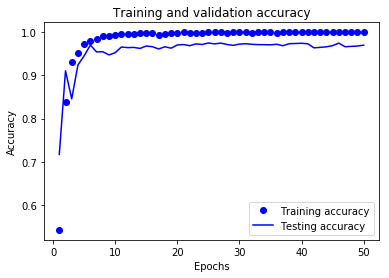

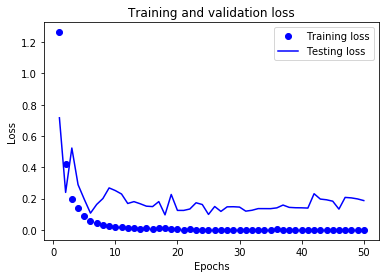

In [6]:
## Plot results
print(len(all_history))

average_acc = [np.mean([x["acc"][i] for x in all_history]) for i in range(50)]
average_loss = [np.mean([x["loss"][i] for x in all_history]) for i in range(50)]
average_val_acc = [np.mean([x["val_acc"][i] for x in all_history]) for i in range(50)]
average_val_loss = [np.mean([x["val_loss"][i] for x in all_history]) for i in range(50)]

plt.plot(range(1, len(average_acc) + 1), average_acc, 'bo', label = 'Training accuracy')
plt.plot(range(1, len(average_val_acc) + 1), average_val_acc, 'b', label = 'Testing accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataSEIs/acc_history')

plt.figure()

plt.plot(range(1, len(average_loss) + 1), average_loss, 'bo', label = 'Training loss')
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, 'b', label = 'Testing loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataSEIs/loss_history')

plt.show()

In [ ]:
print(np.argmax(average_val_acc))
print(np.argmin(average_val_loss))

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

def evaluate_model(k, confusion_matrices):

    train, validation, test = split_data(subjects_data=subjects_data, foldIteration=k, test_sub=None)
    validation_images = validation["images"]; validation_labels = validation["labels"]

    # Load best model from checkpoint of current fold
    model = load_model('/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/modelsGEIs/model{}.hdf5'.format(k))
    
    # Check validation accuracy
    results = model.evaluate(validation_images, validation_labels)
    print(results)

    predictions = model.predict(validation_images)
    conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predictions, axis=1))
    confusion_matrices.append(conf_mat)

In [ ]:
# Load best models of each fold and compute confusion matrices
confusion_matrices = Manager().list()
for k in range(1,11):
    p = Process(target=evaluate_model, args=(k, confusion_matrices))
    p.start()
    p.join()

# Convert manager list back to normal list
conf_matrices = [item for item in confusion_matrices]

# Store list with confusion matrices from every fold
with open("/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataGEIs/confusion_matrices", 'wb') as f:
    pickle.dump(conf_matrices,f)

In [4]:
with open("/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataSEIs/confusion_matrices", 'rb') as f:
    confusion_matrices = pickle.load(f)

[[0.96875    0.         0.         0.         0.03125   ]
 [0.00660569 0.98500615 0.00526316 0.         0.003125  ]
 [0.         0.00263158 0.97179371 0.02557471 0.        ]
 [0.         0.         0.00833333 0.99166667 0.        ]
 [0.         0.         0.         0.         1.        ]]
0.9834433052247945


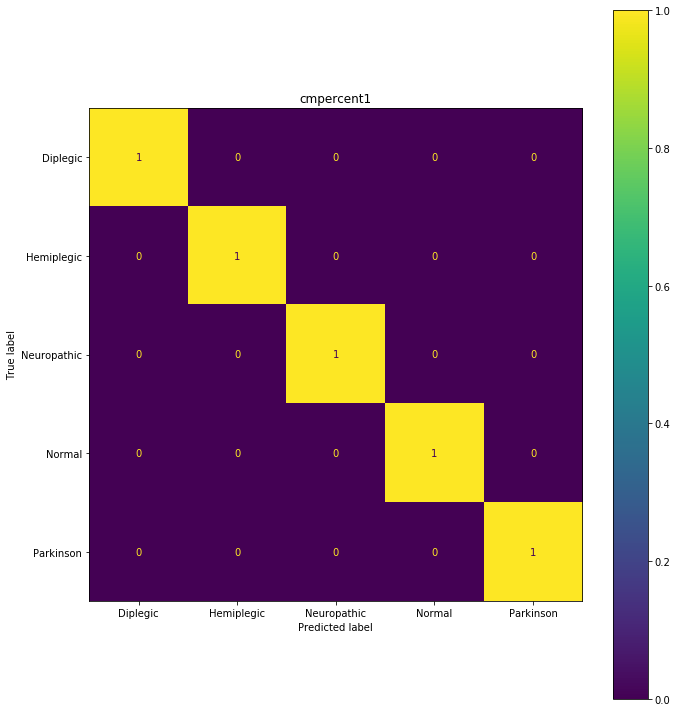

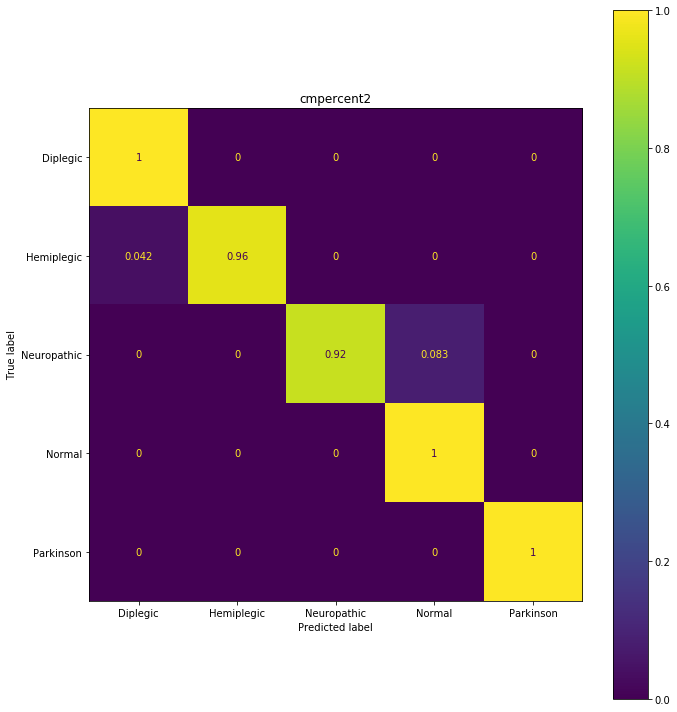

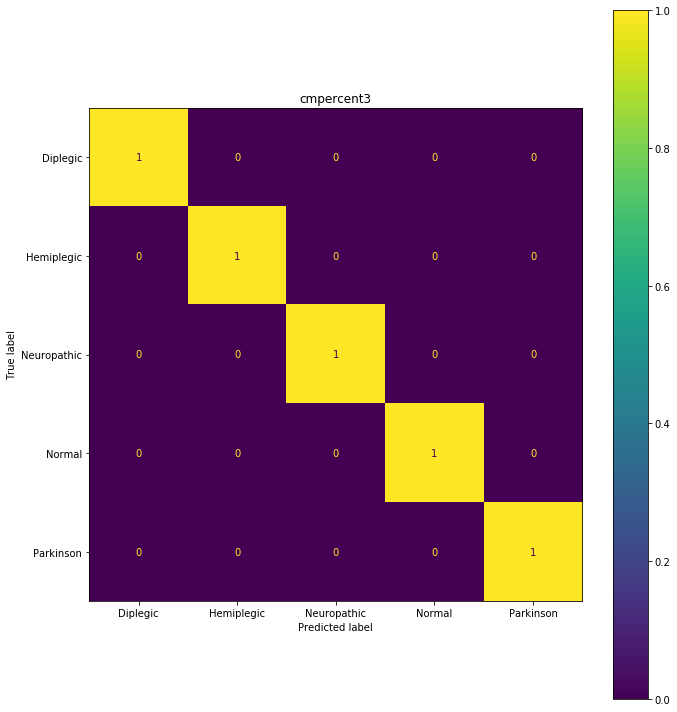

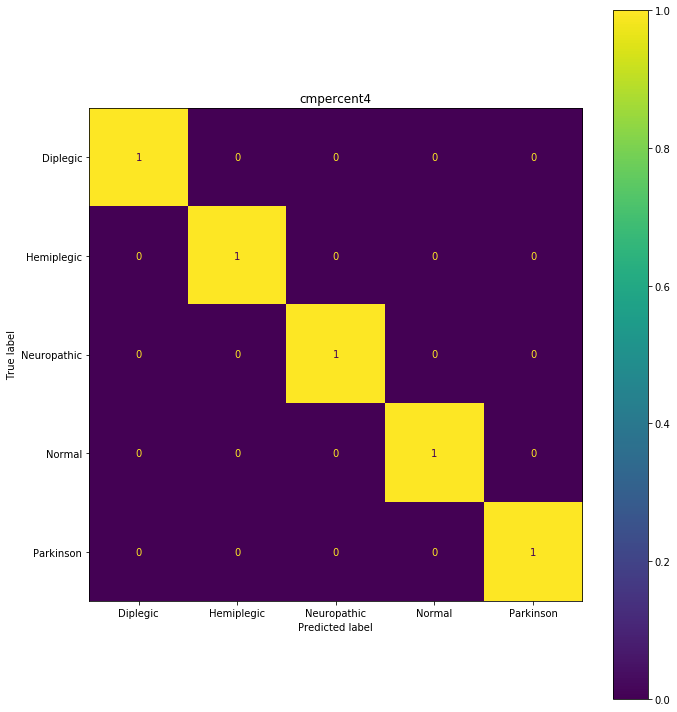

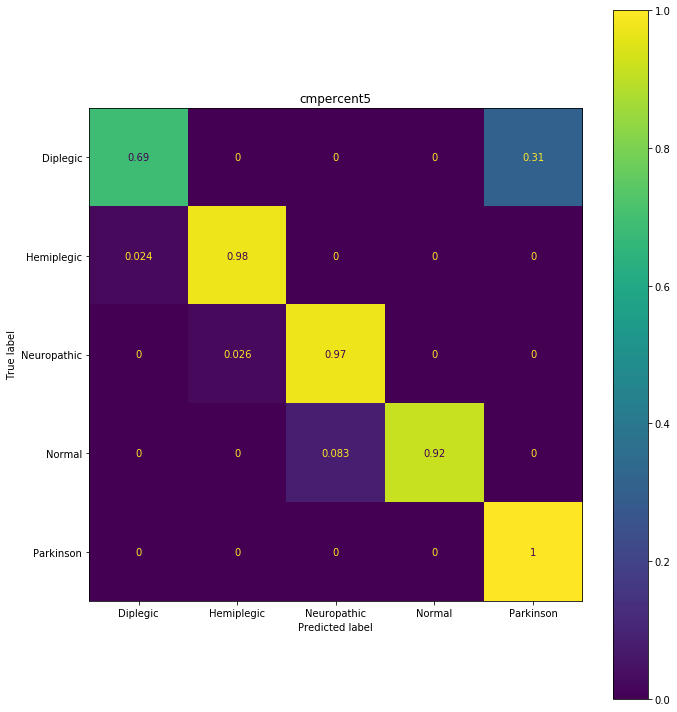

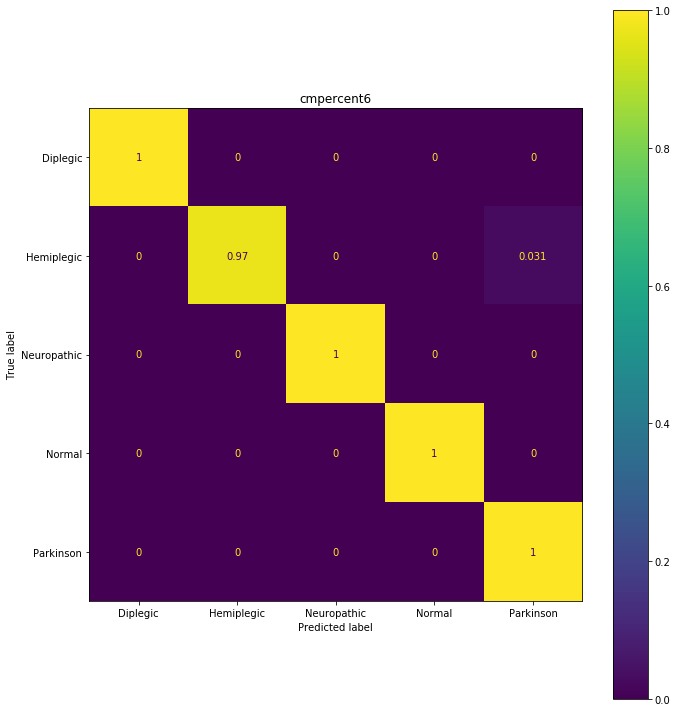

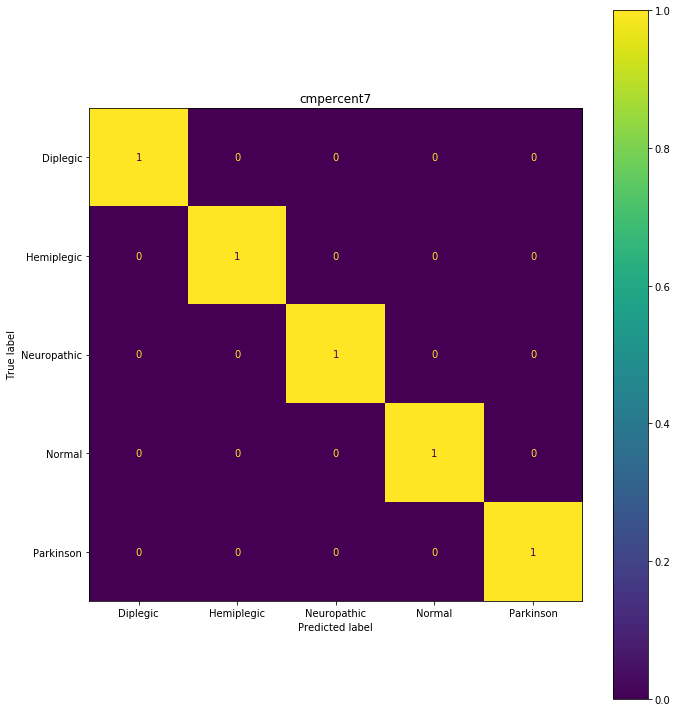

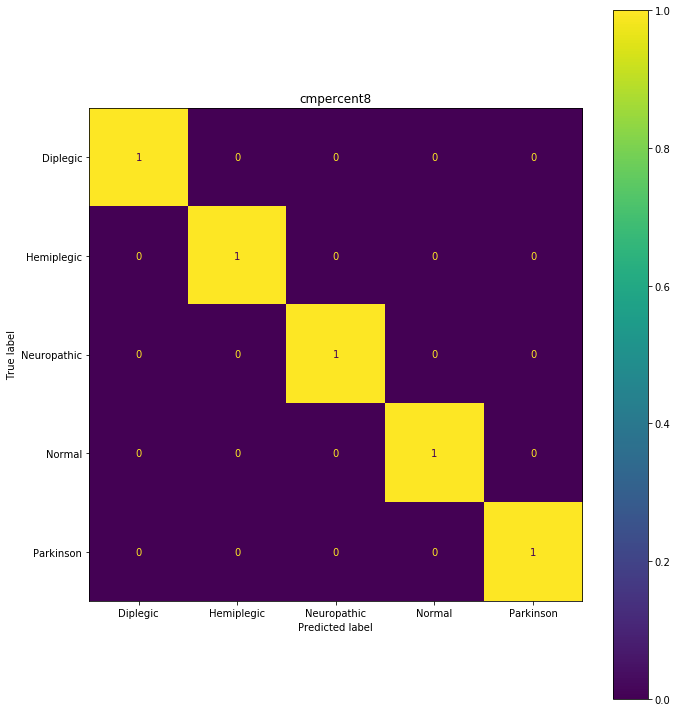

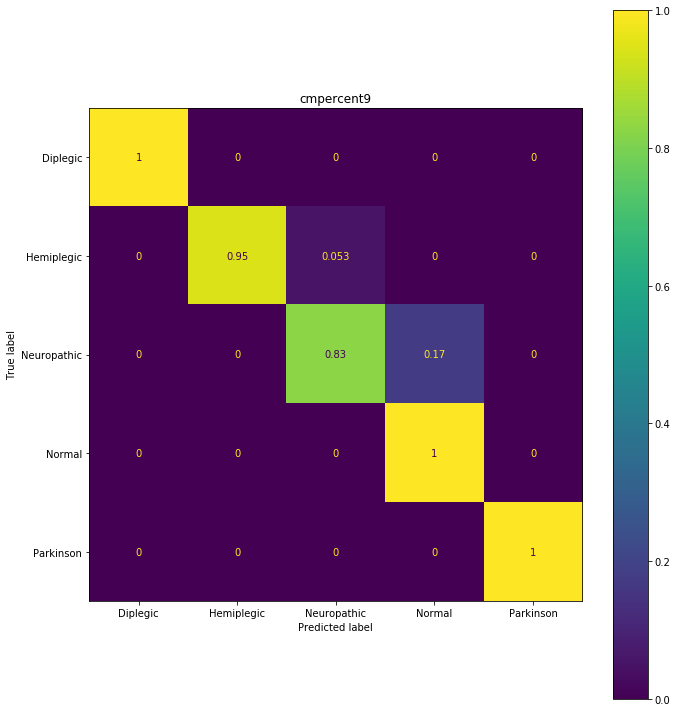

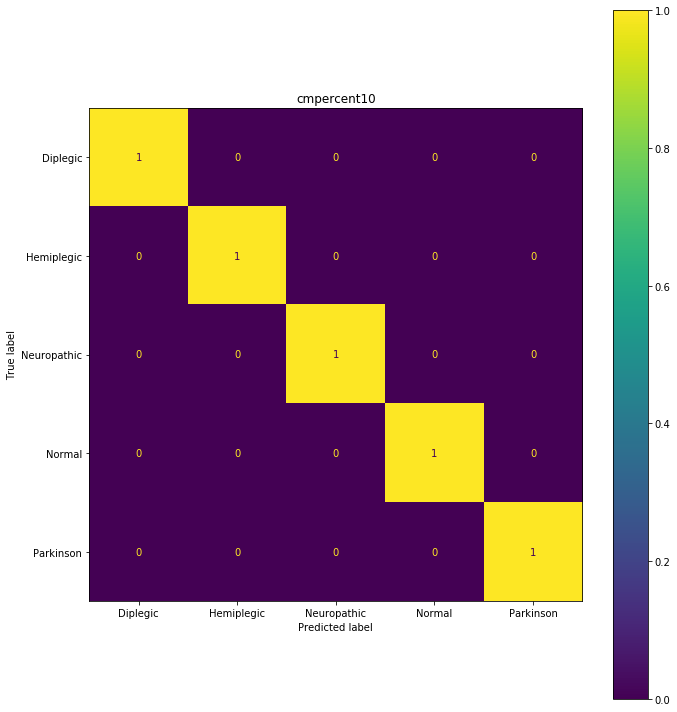

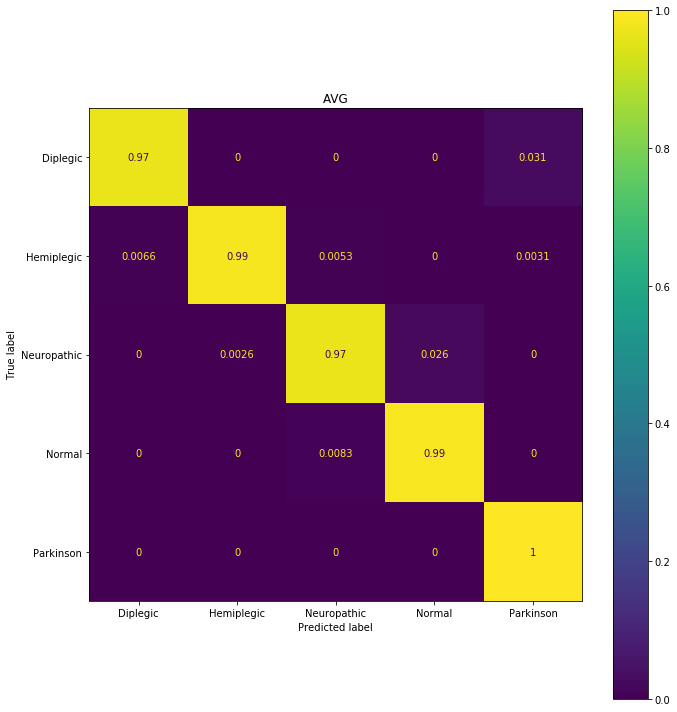

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

# Function to display confusion matrices
def DisplayCM(CM, title, save):

    display_labels = ['Diplegic', 'Hemiplegic', 'Neuropathic', 'Normal', 'Parkinson']
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                                display_labels=display_labels)
    disp = disp.plot(include_values=True,
                    cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.title(title)
    plt.tight_layout()

    #if save: plt.savefig('/home/pfa/Documents/Code/VGG19/Train_GAIT_IST/dataGEIs/Confusion Matrices/' + title)


# Initialize normalized and average CMs and normalized CMs list
cmAVG = np.zeros((5,5))
cmpercent = np.zeros((5,5))
cmpercentList = []

i = 1
# Create list for eachconfusion matrix in percentages
for cm in confusion_matrices:
    display_labels = ['Diplegic', 'Hemiplegic', 'Neuropathic', 'Normal', 'Parkinson']

    cmpercent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmpercentList.append(cmpercent)

   # Plot average CM of current model
    DisplayCM(CM=cmpercent, title='cmpercent{}'.format(i), save=True)
    i += 1


for i in range(0,5):
    for j in range(0,5):
        cmAVG[i][j] = np.mean([x[i][j] for x in cmpercentList])

# Plot average CM of current model
DisplayCM(CM=cmAVG, title='AVG', save=True)

print(cmAVG)
print(np.mean([cmAVG[0][0],cmAVG[1][1], cmAVG[2][2], cmAVG[3][3], cmAVG[4][4]]))